# Import The Dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm

# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, LSTM
# from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from matplotlib import pyplot as plt
from matplotlib import rcParams

import sys
import time

from collections import Counter

from datasets import Dataset
from transformers import AutoTokenizer

from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch
from transformers import DataCollatorWithPadding
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

sys.path.append("../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

KeyboardInterrupt: 

# Prepare data

In [2]:
all_data = pd.read_csv("../lstm_lo_steps_prediction/data/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

# make test/train split
x_train, x_test, y_train_, y_test_ = train_test_split(all_data["simple_terms"].tolist(),
                                                      all_data["steps_num_lo"].tolist(),
                                                      test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train_)}")
print(f"Count testing samples: {len(y_test_)}")

Count all terms: 4251

Count original terms: 4251

max steps count: 30
min steps count: 0
Count training samples: 2952
Count testing samples: 739


In [3]:
train_df = pd.DataFrame({"term_str": x_train, "steps_lo": y_train_})
test_df = pd.DataFrame({"term_str": x_test, "steps_lo": y_test_})

In [4]:
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

In [5]:
# The path of the model checkpoint we want to use

model_dir = './fine_models/input/huggingface-bert/bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_dir)

In [14]:
tokenizer(train_ds['term_str'][20], truncation=True, padding='max_length', max_length=512)

{'input_ids': [101, 113, 137, 193, 119, 113, 113, 113, 113, 193, 113, 193, 113, 193, 113, 193, 193, 114, 114, 114, 114, 193, 114, 113, 137, 193, 119, 193, 114, 114, 113, 113, 113, 113, 113, 193, 113, 137, 193, 119, 113, 137, 193, 119, 113, 137, 193, 119, 193, 114, 114, 114, 114, 113, 137, 193, 119, 193, 114, 114, 193, 114, 193, 114, 113, 113, 113, 137, 193, 119, 193, 114, 193, 114, 193, 114, 114, 114, 114, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [15]:
def preprocess(example):
    # Tokenize the prompt
    tokenized_example = tokenizer(example['term_str'], truncation=True, padding='max_length', max_length=512)
    tokenized_example['label'] = example['steps_lo']
    return tokenized_example

In [16]:
tokenized_train_ds = train_ds.map(preprocess, batched=False,
                                  remove_columns=['term_str', 'steps_lo'])

tokenized_test_ds = test_ds.map(preprocess, batched=False,
                                remove_columns=['term_str', 'steps_lo'])

Map:   0%|          | 0/2952 [00:00<?, ? examples/s]

Map:   0%|          | 0/739 [00:00<?, ? examples/s]

In [17]:
tokenized_train_ds.data

InMemoryTable
input_ids: list<item: int32>
  child 0, item: int32
token_type_ids: list<item: int8>
  child 0, item: int8
attention_mask: list<item: int8>
  child 0, item: int8
label: int64
----
input_ids: [[[101,113,113,113,137,...,0,0,0,0,0],[101,113,113,113,113,...,0,0,0,0,0],...,[101,113,113,137,193,...,0,0,0,0,0],[101,113,113,113,113,...,0,0,0,0,0]],[[101,113,137,193,119,...,0,0,0,0,0],[101,113,137,193,119,...,0,0,0,0,0],...,[101,113,137,193,119,...,0,0,0,0,0],[101,113,113,113,113,...,0,0,0,0,0]],[[101,113,137,193,119,...,0,0,0,0,0],[101,113,113,113,113,...,113,113,137,193,102],...,[101,113,113,113,137,...,0,0,0,0,0],[101,113,113,137,193,...,0,0,0,0,0]]]
token_type_ids: [[[0,0,0,0,0,...,0,0,0,0,0],[0,0,0,0,0,...,0,0,0,0,0],...,[0,0,0,0,0,...,0,0,0,0,0],[0,0,0,0,0,...,0,0,0,0,0]],[[0,0,0,0,0,...,0,0,0,0,0],[0,0,0,0,0,...,0,0,0,0,0],...,[0,0,0,0,0,...,0,0,0,0,0],[0,0,0,0,0,...,0,0,0,0,0]],[[0,0,0,0,0,...,0,0,0,0,0],[0,0,0,0,0,...,0,0,0,0,0],...,[0,0,0,0,0,...,0,0,0,0,0],[0,0,0,0,0,..

In [19]:
# Following datacollator (adapted from https://huggingface.co/docs/transformers/tasks/multiple_choice)
# will dynamically pad our questions at batch-time so we don't have to make every question the length
# of our longest question.
# Since it's no longer a multiple-choice problem, we can use a simpler data collator

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
# Use BertForSequenceClassification instead of AutoModelForMultipleChoice

model = AutoModelForSequenceClassification.from_pretrained(model_dir, num_labels=31)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./fine_models/input/huggingface-bert/bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# The arguments here are selected to run quickly; feel free to play with them.
model_dir = 'finetuned_bert'
training_args = TrainingArguments(
    output_dir=model_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to='none'
)

In [22]:
# Generally it's a bad idea to validate on your training set, but because our training set
# for this problem is so small we're going to train on all our data.

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_train_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

In [45]:
# Training should take about a minute
train_log = trainer.train()

Epoch,Training Loss,Validation Loss


In [46]:
train_log

TrainOutput(global_step=7380, training_loss=2.9779853965531844, metrics={'train_runtime': 3029.5553, 'train_samples_per_second': 9.744, 'train_steps_per_second': 2.436, 'total_flos': 7769060730224640.0, 'train_loss': 2.9779853965531844, 'epoch': 10.0})

In [47]:
train_preds = trainer.predict(tokenized_train_ds)
test_preds = trainer.predict(tokenized_test_ds)

In [48]:
train_preds.predictions

array([[ 0.50129145,  0.94814306,  0.95199376, ..., -2.1896634 ,
        -2.3642564 , -2.4146569 ],
       [ 0.50129145,  0.94814306,  0.95199364, ..., -2.1896634 ,
        -2.3642564 , -2.4146569 ],
       [ 0.50129145,  0.948143  ,  0.95199376, ..., -2.1896634 ,
        -2.3642564 , -2.4146569 ],
       ...,
       [ 0.50129145,  0.94814306,  0.95199376, ..., -2.1896634 ,
        -2.3642564 , -2.4146569 ],
       [ 0.50129145,  0.94814306,  0.95199376, ..., -2.1896634 ,
        -2.3642564 , -2.4146569 ],
       [ 0.50129145,  0.94814306,  0.95199376, ..., -2.1896634 ,
        -2.3642564 , -2.4146569 ]], dtype=float32)

In [49]:
train_preds_nums = [np.argmax(x_) for x_ in train_preds.predictions]
test_preds_nums = [np.argmax(x_) for x_ in test_preds.predictions]

In [50]:
train_preds_nums

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [51]:
tokenized_train_ds

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 2952
})

In [53]:
train_true_nums = tokenized_train_ds['label']
test_true_nums = tokenized_test_ds['label']

In [29]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

Train accuracy: 0.11043360433604336


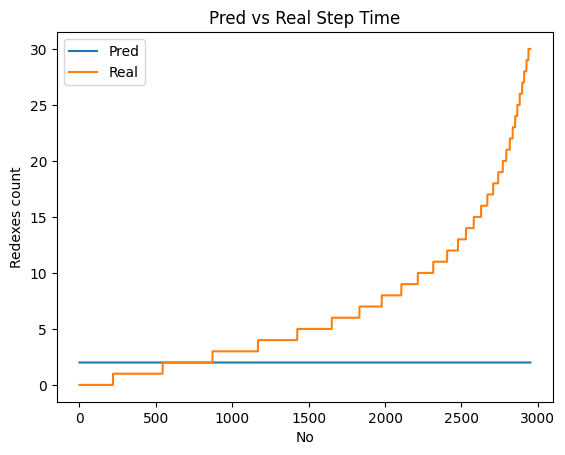

In [54]:
print("Train accuracy:", calculate_accuracy(train_true_nums, train_preds_nums))
draw_pred_lines(train_preds_nums, train_true_nums)

Test accuracy: 0.10013531799729364


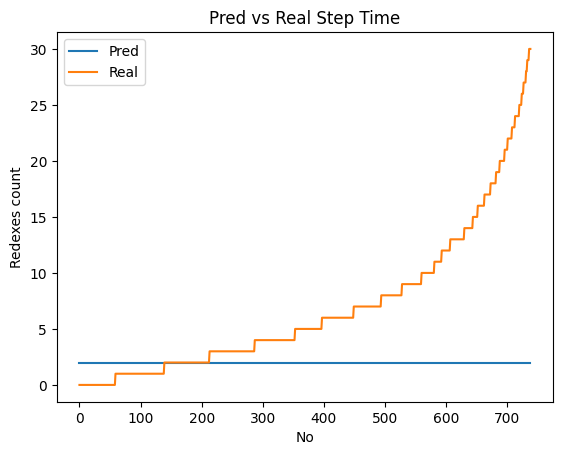

In [55]:
print("Test accuracy:", calculate_accuracy(test_true_nums, test_preds_nums))
draw_pred_lines(test_preds_nums, test_true_nums)

# Do additional metrics testing

# Mean Squared Error

In [32]:
train_preds_nums = np.array(train_preds_nums)
test_preds_nums = np.array(test_preds_nums)

train_true_nums = np.array(train_true_nums)
test_true_nums = np.array(test_true_nums)

In [33]:
mse_train = mean_squared_error(train_true_nums, train_preds_nums)
print("Train {Mean Squared Error}:", mse_train)

mse_test = mean_squared_error(test_true_nums, test_preds_nums)
print("Test {Mean Squared Error}:", mse_test)

Train {Mean Squared Error}: 64.43055555555556
Test {Mean Squared Error}: 66.48849797023004


## Mean Absolute Error

In [34]:
mae_train = mean_absolute_error(train_true_nums, train_preds_nums)
print("Train {Mean Absolute Error}:", mae_train)

mae_test = mean_absolute_error(test_true_nums, test_preds_nums)
print("Test {Mean Absolute Error}:", mae_test)

Train {Mean Absolute Error}: 5.2903116531165315
Test {Mean Absolute Error}: 5.422192151556157


## Mean Absolute Percentage Error

In [35]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    percentage_errors = np.abs((y_true - y_pred) / y_true_fix) * 100
    mape = np.mean(percentage_errors)
    return mape


mape_train = mean_absolute_percentage_error(train_true_nums, train_preds_nums)
print("Train {Mean Absolute Percentage Error}:", mape_train)

mape_test = mean_absolute_percentage_error(test_true_nums, test_preds_nums)
print("Test {Mean Absolute Percentage Error}:", mape_test)

Train {Mean Absolute Percentage Error}: 149110.04624916063
Test {Mean Absolute Percentage Error}: 159734.29248114064


## Percentage of Explained Variance (PEV)

In [36]:
# Calculate Variance of the target variable
variance_y_train = np.var(train_true_nums)
variance_y_test = np.var(test_true_nums)

# Calculate Percentage of Explained Variance (PEV)
pev_test = (1 - mse_test / variance_y_test) * 100
pev_train = (1 - mse_train / variance_y_train) * 100

print("Train {Percentage of Explained Variance}:", pev_train)
print("Test {Percentage of Explained Variance}:", pev_test)

Train {Percentage of Explained Variance}: -54.66405393128424
Test {Percentage of Explained Variance}: -56.03142202950537


## Mean Bias Deviation

In [37]:
def mean_bias_deviation(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    n = len(y_true)
    mbd = np.sum((y_pred - y_true) / y_true_fix) * 100 / n
    return mbd


mbd_train = mean_bias_deviation(train_true_nums, train_preds_nums)
print("Train {Mean Bias Deviation}:", mbd_train)

mdb_test = mean_bias_deviation(test_true_nums, test_preds_nums)
print("Test {Mean Bias Deviation}:", mdb_test)

Train {Mean Bias Deviation}: 149014.95154916254
Test {Mean Bias Deviation}: 159637.82984654544


## Coefficient of Correlation (Pearson's r)

In [38]:
coc_test = np.corrcoef(train_preds_nums, train_true_nums)[0, 1]
coc_train = np.corrcoef(test_preds_nums, test_true_nums)[0, 1]

print("Train {Mean Bias Deviation}:", coc_train)
print("Test {Mean Bias Deviation}:", coc_test)

Train {Mean Bias Deviation}: nan
Test {Mean Bias Deviation}: nan


D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# ERROR STD

In [39]:
train_error = train_true_nums - train_preds_nums
test_error = test_true_nums - test_preds_nums
print("Train Error STD:", np.abs(train_error).std())
print("Test Error STD:", np.abs(test_error).std())

Train Error STD: 6.036816890419569
Test Error STD: 6.0900189032410115


In [40]:
def advanced_point_drawer(y_real, y_pred, title="Train dataset"):
    counter = Counter([(x_, y_) for x_, y_ in zip(y_real, y_pred)])
    coords_count = dict(counter)

    plt.figure(figsize=(12, 12))

    coords_count_rev = dict()
    for key_, val_ in coords_count.items():
        if val_ not in coords_count_rev:
            coords_count_rev[val_] = []
        coords_count_rev[val_].append(key_)

    tcoords_count_rev = dict()
    for key_ in sorted(coords_count_rev.keys()):
        tcoords_count_rev[key_] = coords_count_rev[key_]

    coords_count_rev = tcoords_count_rev

    for key_, val_ in coords_count_rev.items():
        coords_data = np.array(val_)
        plt.scatter(coords_data[:, 0], coords_data[:, 1], s=key_ ** 1 + 5, c='tab:blue', label=f"\n{key_}\n")

    plt.plot([0, 31], [0, 31], c="gray", linestyle="--")
    plt.axis("equal")
    plt.xlabel("Real", fontsize=18)
    plt.ylabel("Predict", fontsize=18)
    plt.title(title, fontsize=20)
    plt.legend(prop={'size': 10})
    plt.show()

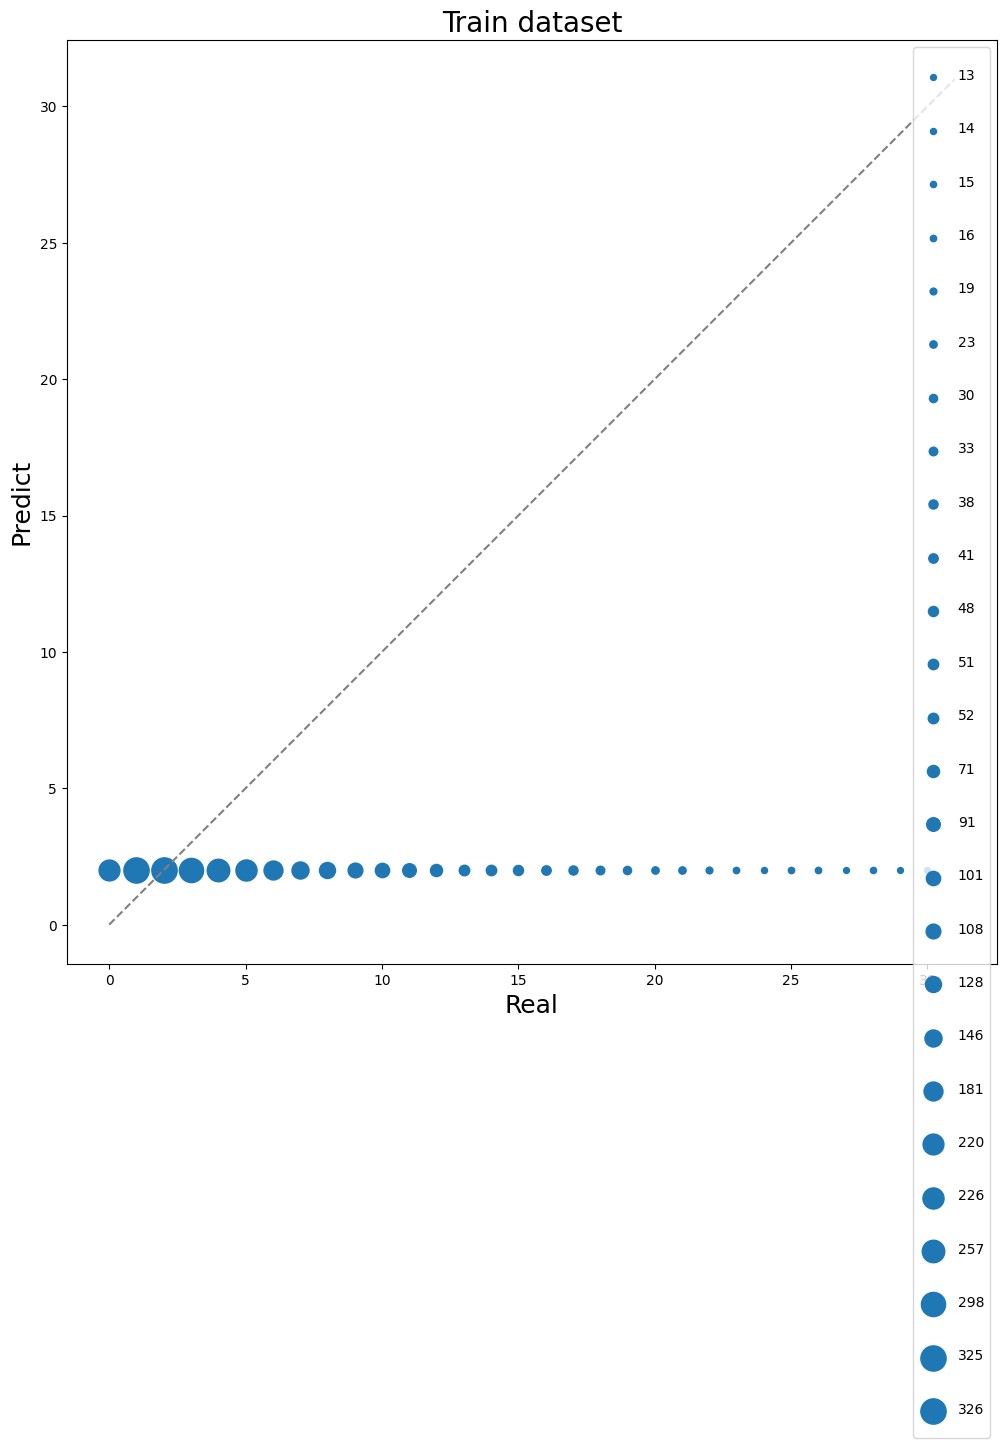

In [41]:
advanced_point_drawer(train_true_nums, train_preds_nums)

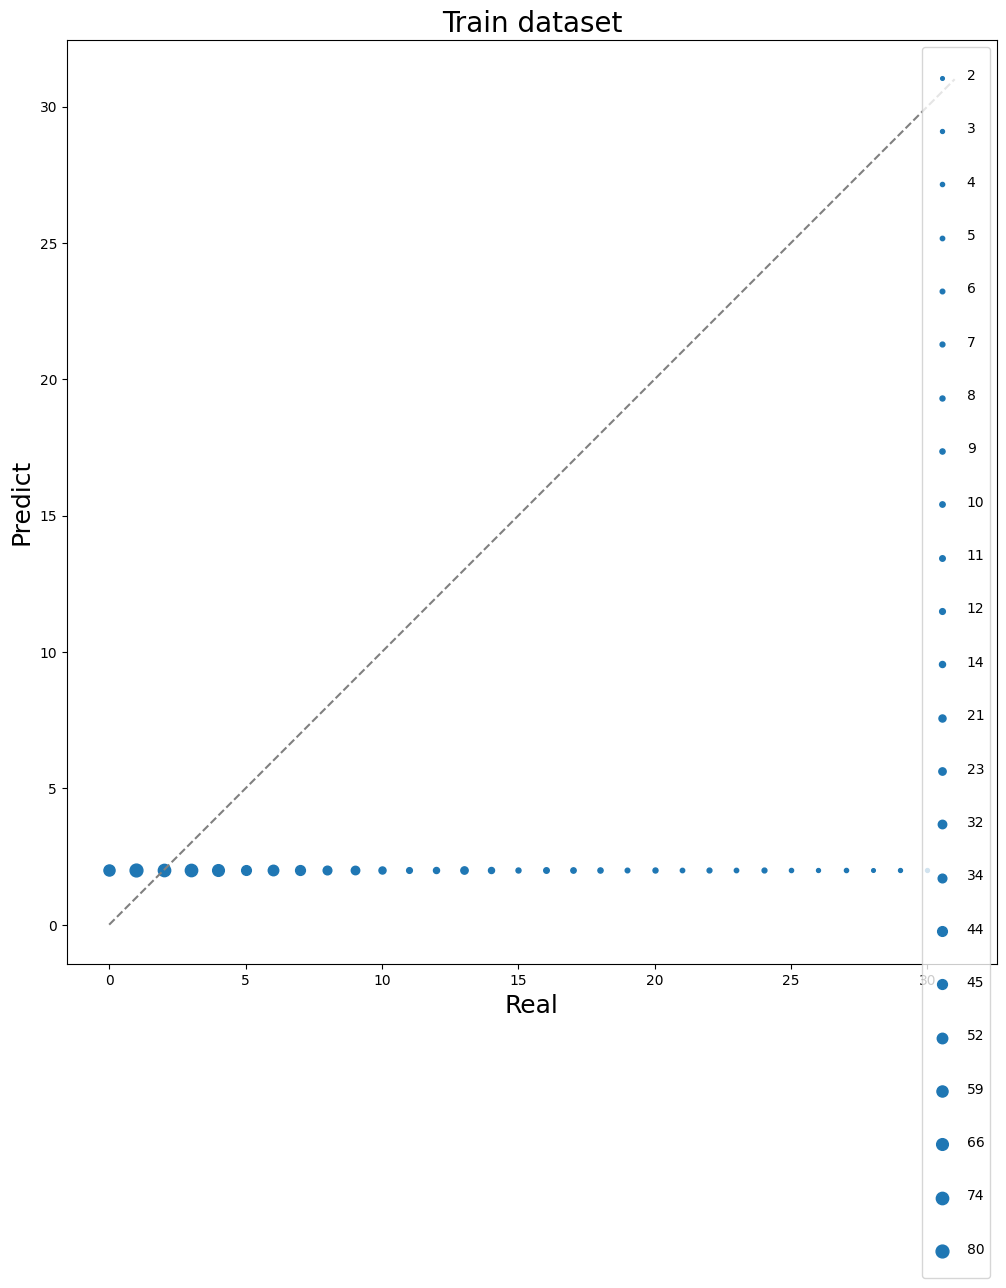

In [42]:
advanced_point_drawer(test_true_nums, test_preds_nums)